## Librerias

In [2]:
import os
import statistics
import xgboost
import time

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

## Funciones varias

In [38]:
#Funcion que retorna el arreglo de matriz de confusion promedio y desviacion estandar.

def matrices(conf_mat): 
    #==============PROMEDIO CM ==============#
    suma = conf_mat[0]-conf_mat[0]
    for i in range(5):
      suma= suma + conf_mat[i]
    promedio = suma/5     #Arreglo con el promedio de cada valor de la matriz

    #==============DESVIACION CM==============#
    suma2= conf_mat[0]-conf_mat[0]
    desv= []

    for i in range(5):
      vac= conf_mat[0]-conf_mat[0]
      for m in range(conf_mat[0].shape[0]):
        for n in range(conf_mat[0].shape[0]):
          vac[m][n] = (conf_mat[i][m][n] - promedio[m][n])**2 # Con esto se realiza en cada valor de la matriz la funcion (x-promedio)**2
      desv.append(vac)

    for i in range(5):
      suma2= suma2 + desv[i] #Con esto se realiza la sumatoria de los datos en cada valor de la matriz
    promedio2 = suma2/5 #Se divide la sumatoria en la cantidad de datos 

    for m in range(conf_mat[0].shape[0]):
      for n in range(conf_mat[0].shape[0]):
        promedio2[m][n] = promedio2[m][n]**0.5 #Se aplica finalmente la raiz cuadrada a cada valor
    #====================================#
    CM_DESV = conf_mat[0]-conf_mat[0]
    for m in range(conf_mat[0].shape[0]):
      for n in range(conf_mat[0].shape[0]):
        CM_DESV[m][n] = round(promedio2[m][n]*100,1) #Se añaden las desviaciones a un arreglo 

    return (promedio, CM_DESV)

In [4]:
#Funcion que retorna las metricas macro

def metricas(mc):
    presicion=[]
    recall = []
    f1_score=[]

    for l in range(len(mc)):
        columna= mc[:,l]
        fila =mc[l,:]
        pres=columna[l]/sum(columna)
        reca=fila[l]/sum(fila)
        presicion.append(pres)
        recall.append(reca)
        f1_score.append(2*pres*reca/(pres+reca))

    macro_presicion = statistics.mean(presicion)
    macro_recall = statistics.mean(recall)
    macro_f1_score = statistics.mean(f1_score)
    
    return macro_presicion,macro_recall,macro_f1_score

In [5]:
#Funcion que grafica una matriz de confusion con predicciones

def plot_confusion_matrix(
    y_test,
    y_pred,
    classes,
    normalize=True,
    ax=None,
    fontsize = 8,
    dpi = 90,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)
        fig.tight_layout()
        plt.rcParams.update({'font.size': fontsize})
        
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        cmap=plt.cm.Blues,
        normalize="true" if normalize else None,
        ax=ax,
        colorbar=False
    )
    
    title = f"Matriz de confusion{' no' if not normalize else ''} normalizada"
    
    ax.set_title(title, fontsize= 10)
  
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes, rotation=45, fontsize= 8)
    ax.set_yticks(tick_marks, classes, fontsize= 8)
    ax.set_ylabel("True label", fontsize= 10)
    ax.set_xlabel("Predicted label", fontsize= 10)
    ax.grid(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

target_names_clases = ["RR Lyrae","EB","Cefeidas"]

target_names_RRL = ["RRab","RRc","RRd","RRe"]
target_names_EB = ['EC',"ED_ESD","ED_VAR","ELL_EC"]
target_names_CEF =["1O","1O_20","F"]

target_final = ["RRab","RRc","RRd","RRe",'EC',"ED_ESD","ED_VAR","ELL_EC","1O","1O_20","F"]

In [98]:
#Funcion que grafica una matriz de confusion promedio con desviacion estandar

def plot_confusion_matrix_2(cm, cms,  classes,
                          cmap=plt.cm.Blues, fontsize_valores=12, fontsize_label=10, fontsize_eje = 12):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize= fontsize_label)
    plt.yticks(tick_marks, classes, fontsize= fontsize_label)
    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{0:.2f}'.format(cm[i, j]) + '\n$\pm$' + '{0:.1f}'.format(cms[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center", fontsize=fontsize_valores,
                     color="white" if cm[i, j] > thresh else "black")



    plt.tight_layout()
    plt.ylabel('True label', fontsize= fontsize_eje)
    plt.xlabel('Predicted label', fontsize= fontsize_eje)

In [ ]:
#Funcion para ver la clasificacion del nivel inferior del clasificador jerarquico

def clase_final_predicha(x):
    predicciones = []
    clase_predicha = clf_clases.predict(x)
    for m in range(len(clase_predicha)):

        if clase_predicha[m]==0:
            subclase_predicha = clf_BRF_RRL.predict(test_todos_RRL.values[m].reshape(1, -1))
            predicciones.append(subclase_predicha[0])

        elif clase_predicha[m] ==1:
            subclase_predicha = clf_BRF_EB.predict(test_todos_EB.values[m].reshape(1, -1))
            predicciones.append(subclase_predicha[0]+4)

        else:
            if clase_predicha[m] == 2:
                subclase_predicha = clf_BRF_CEF.predict(test_todos_CEF.values[m].reshape(1, -1))
                predicciones.append(subclase_predicha[0]+11)
                    
    return predicciones

In [ ]:
# Truco para eliminar datos que tengan valores infinitos para hacer el ranking con todas las caracteristicas
lista_inf_CEF=[]
valores1=dataset_subclases[["GP_DRW_sigma_b"]].values
suma=0
for i in range(len(valores1)):
    if valores1[i].astype(np.float32) == np.inf:
        lista_inf_CEF.append(i)
        suma+=1
print(suma)

valores2=dataset_subclases[["GP_DRW_tau_r"]].values
suma=0
for i in range(len(valores1)):
    if valores2[i].astype(np.float32) == np.inf:
        lista_inf_CEF.append(i)
        suma+=1
print(suma)

valores3=dataset_subclases[["GP_DRW_tau_b"]].values
suma=0
for i in range(len(valores1)):
    if valores3[i].astype(np.float32) == np.inf:
        lista_inf_CEF.append(i)
        suma+=1
print(suma)

#Con esto se eliminan todos los vectores que posean valores infinitos
#lista_inf_final_CEF=[]
#for x in lista_inf_CEF:
#    if x not in lista_inf_final_CEF:
#        lista_inf_final_CEF.append(x)

In [77]:
#Funciones para hacer cross-validation con k=5 y funcion objetivo macro_recall

################################ Para XGBoost ################################
xgb= xgboost.XGBClassifier()
parametros= {'learning_rate':[0.6,0.65,0.7],
            'n_estimators':[700,800,900],
}

clasificador= GridSearchCV(xgb, parametros, cv=5, scoring="recall_macro")
#clasificador.fit(train_clases.values, np.ravel(label_train_clases.values))# Se le entrega el set de entrenamiento respectivo

#Se imprimen los mejores parametros
#clasificador.best_params_

################################ Para BRF ################################
brf= BalancedRandomForestClassifier()
parametros= {'n_estimators':[600,700,800],
}

clasificador= GridSearchCV(brf, parametros, cv=5, scoring="recall_macro")
#clasificador.fit(train_clases.values, np.ravel(label_train_clases.values))# Se le entrega el set de entrenamiento respectivo

#Se imprimen los mejores parametros
#clasificador.best_params_

## Dataset

In [7]:
dataset_RRL=pd.read_excel(".\Features\subclases_RRL_final.xlsx")
dataset_EB=pd.read_excel(".\Features\subclases_EB_final.xlsx")
dataset_CEF=pd.read_excel(".\Features\subclases_cefeidas_final_3.xlsx")


dataset_EB_subclases=pd.read_excel(".\Features\subclases_EB_final_menos_sub.xlsx")

In [9]:
train_clases_RRL , test_clases_RRL = train_test_split(dataset_RRL, test_size=0.2, random_state=42)
train_clases_EB , test_clases_EB = train_test_split(dataset_EB, test_size=0.2, random_state=42)
train_clases_CEF , test_clases_CEF = train_test_split(dataset_CEF, test_size=0.2, random_state=42)

train_clases_EB_sub, test_clases_EB_sub = train_test_split(dataset_EB_subclases, test_size=0.2, random_state=42)

caracteristicas_malas = ["clase","subclase","subclase2",'oid']

#Se usaron 31 caracteristicas
caracteristicas_irrelevantes_clases = ['PairSlopeTrend_b', 'GP_DRW_sigma_b', 'Skew_b', 'StetsonK_b', 'GP_DRW_sigma_r', 'Multiband_period', 'Std_b', 'SmallKurtosis_b', 'Psi_CS_r', 'Harmonics_mag_1_r', 'Harmonics_phase_7_r', 'Harmonics_phase_4_r', 'MHPS_ratio_r', 'Power_rate_4', 'Harmonics_mag_5_r', 'Period_band_b', 'IAR_phi_r', 'IAR_phi_b', 'PPE', 'MHPS_high_r', 'MaxSlope_r', 'Harmonics_mag_2_r', 'Power_rate_1/2', 'Con_r', 'Harmonics_mag_4_r', 'Psi_CS_b', 'Eta_e_b', 'Power_rate_3', 'SmallKurtosis_r', 'Meanvariance_b', 'Con_b', 'Harmonics_mag_6_r', 'Harmonics_phase_2_r', 'Harmonics_phase_6_r', 'Harmonics_phase_5_b', 'Rcs_b', 'LinearTrend_r', 'Rcs_r', 'Psi_eta_b', 'Eta_e_r', 'Harmonics_phase_2_b', 'Harmonics_phase_5_r', 'delta_period_b', 'MaxSlope_b', 'Harmonics_mag_3_b', 'Harmonics_mag_1_b', 'Harmonics_mag_2_b', 'Harmonics_phase_7_b', 'Power_rate_2', 'Harmonics_mag_3_r', 'GP_DRW_tau_b', 'Harmonics_mag_6_b', 'Power_rate_1/3', 'Harmonics_mag_7_b', 'Harmonics_phase_3_b', 'Autocor_length_r', 'Harmonics_phase_4_b', 'Harmonics_phase_6_b', 'Harmonics_phase_3_r', 'Harmonics_mag_4_b', 'GP_DRW_tau_r', 'Psi_eta_r', 'Harmonics_mag_7_r', 'Power_rate_1/4', 'Harmonics_mag_5_b', 'StetsonK_r', 'MedianBRP_b', 'Skew_r', 'SF_ML_gamma_r', 'SF_ML_gamma_b', 'SF_ML_amplitude_r', 'SF_ML_amplitude_b', 'Q31_r', 'Q31_b', 'MHPS_non_zero_b', 'MHPS_PN_flag_r', 'MHPS_PN_flag_b', 'ExcessVar_r', 'ExcessVar_b', 'AndersonDarling_r', 'AndersonDarling_b']

#Se usaron 74 caracteristicas
caracteristicas_irrelevantes_RRL = ["GP_DRW_sigma_b","GP_DRW_tau_r","GP_DRW_tau_b",'Power_rate_3', 'Harmonics_phase_7_b', 'Power_rate_4', 'Psi_CS_b', 'Harmonics_mag_7_r', 'Harmonics_mag_3_b', 'Harmonics_phase_6_b', 'Harmonics_mag_3_r', 'Harmonics_mag_2_b', 'Harmonics_phase_6_r', 'MaxSlope_b', 'Mean_r', 'MedianAbsDev_r', 'Harmonics_mag_1_r', 'GP_DRW_tau_r', 'Harmonics_mag_7_b', 'Skew_r', 'Harmonics_mag_6_b', 'IAR_phi_r', 'SmallKurtosis_r', 'Std_b', 'SF_ML_gamma_r', 'SF_ML_gamma_b', 'SF_ML_amplitude_r', 'SF_ML_amplitude_b', 'Q31_r', 'Q31_b', 'MedianBRP_b', 'MHPS_non_zero_b', 'MHPS_PN_flag_r', 'MHPS_PN_flag_b', 'ExcessVar_r', 'ExcessVar_b', 'AndersonDarling_r', 'AndersonDarling_b']

#Se usaron 77 caracteristicas
caracteristicas_irrelevantes_EB = ["GP_DRW_sigma_b","GP_DRW_tau_r","GP_DRW_tau_b",'Harmonics_mag_1_r', 'StetsonK_b', 'IAR_phi_b', 'Mean_r', 'Skew_b', 'Period_band_r', 'Std_r', 'Multiband_period', 'Skew_r', 'Beyond1Std_r', 'PairSlopeTrend_b', 'PPE', 'StetsonK_r', 'SmallKurtosis_b', 'MedianBRP_r', 'MedianBRP_b', 'Con_r', 'Pvar_r', 'Autocor_length_b', 'Pvar_b', 'delta_period_r', 'SF_ML_gamma_r', 'SF_ML_gamma_b', 'SF_ML_amplitude_r', 'SF_ML_amplitude_b', 'PairSlopeTrend_r', 'MHPS_PN_flag_r', 'MHPS_PN_flag_b', 'ExcessVar_r', 'ExcessVar_b', 'AndersonDarling_r', 'AndersonDarling_b']

#Se usaron 68 caracteristicas
caracteristicas_irrelevantes_CEF = ["GP_DRW_tau_r","GP_DRW_tau_b",'MedianBRP_r', 'MaxSlope_r', 'Harmonics_phase_6_r', 'PPE', 'Beyond1Std_r', 'Rcs_r', 'Harmonics_mag_5_r', 'Harmonics_mag_4_r', 'Harmonics_phase_7_r', 'GP_DRW_sigma_b', 'Harmonics_mag_5_b', 'Autocor_length_r', 'IAR_phi_b', 'Harmonics_mse_b', 'Harmonics_phase_5_r', 'SmallKurtosis_b', 'GP_DRW_sigma_r', 'Harmonics_mag_2_r', 'Period_band_r', 'Beyond1Std_b', 'MedianBRP_b', 'Harmonics_mag_1_r', 'Harmonics_phase_4_r', 'Harmonics_mag_3_r', 'Con_b', 'Multiband_period', 'Con_r', 'Pvar_r', 'Pvar_b', 'Autocor_length_b', 'delta_period_r', 'PairSlopeTrend_r', 'SF_ML_gamma_r', 'SF_ML_gamma_b', 'SF_ML_amplitude_r', 'SF_ML_amplitude_b', 'MHPS_PN_flag_r', 'MHPS_PN_flag_b', 'ExcessVar_r', 'ExcessVar_b', 'AndersonDarling_r', 'AndersonDarling_b']


#==================RRL=========================#
subclase_train_RRL = train_clases_RRL[["subclase"]]
clase_train_RRL = train_clases_RRL[["clase"]]
label_train_RRL= train_clases_RRL[['subclase2']]
train_RRL = train_clases_RRL.drop(columns= caracteristicas_malas+caracteristicas_irrelevantes_RRL)
train_RRL_2 = train_clases_RRL.drop(columns= caracteristicas_malas+caracteristicas_irrelevantes_clases)

subclase_test_RRL = test_clases_RRL[["subclase"]]
label_test_RRL= test_clases_RRL[['subclase2']]
label_test_clase_RRL = test_clases_RRL[['clase']]
test_RRL = test_clases_RRL.drop(columns=caracteristicas_malas+caracteristicas_irrelevantes_RRL)
test_RRL_EB = test_clases_RRL.drop(columns=caracteristicas_malas+caracteristicas_irrelevantes_EB)
test_RRL_CEF = test_clases_RRL.drop(columns=caracteristicas_malas+caracteristicas_irrelevantes_CEF)
test_RRL_2 = test_clases_RRL.drop(columns= caracteristicas_malas+caracteristicas_irrelevantes_clases)

#===================EB========================#
subclase_train_EB = train_clases_EB_sub[["subclase"]] #Para verificar final
clase_train_EB = train_clases_EB[["clase"]] #Entrenar clase
label_train_EB= train_clases_EB_sub[['subclase2']] #Entrenar subclase
train_EB = train_clases_EB_sub.drop(columns=caracteristicas_malas +caracteristicas_irrelevantes_EB ) #Entrenar subclase
train_EB_2 = train_clases_EB.drop(columns= caracteristicas_malas+caracteristicas_irrelevantes_clases) #Entrenar clase

subclase_test_EB = test_clases_EB_sub[["subclase"]] #Entrenar final
label_test_EB= test_clases_EB_sub[['subclase2']] #Entrenar subclase
label_test_clase_EB = test_clases_EB[['clase']] #Entrenar clase
test_EB = test_clases_EB_sub.drop(columns=caracteristicas_malas+caracteristicas_irrelevantes_EB) #Entrenar subclase
test_EB_RRL = test_clases_EB_sub.drop(columns=caracteristicas_malas+caracteristicas_irrelevantes_RRL) #Entrenar final
test_EB_CEF = test_clases_EB_sub.drop(columns=caracteristicas_malas+caracteristicas_irrelevantes_CEF) #Entrenar final
test_EB_2 = test_clases_EB.drop(columns= caracteristicas_malas+caracteristicas_irrelevantes_clases) #Entrenar clase
test_EB_2_sub = test_clases_EB_sub.drop(columns= caracteristicas_malas+caracteristicas_irrelevantes_clases) #Entrenar clase

#==================CEFEIDAS=========================#
subclase_train_CEF = train_clases_CEF[["subclase"]]
clase_train_CEF = train_clases_CEF[["clase"]]
label_train_CEF= train_clases_CEF[['subclase2']]
train_CEF = train_clases_CEF.drop(columns=caracteristicas_malas+caracteristicas_irrelevantes_CEF)
train_CEF_2 = train_clases_CEF.drop(columns= caracteristicas_malas+caracteristicas_irrelevantes_clases)


subclase_test_CEF = test_clases_CEF[["subclase"]]
label_test_CEF= test_clases_CEF[['subclase2']]
label_test_clase_CEF = test_clases_CEF[['clase']]

test_CEF = test_clases_CEF.drop(columns=caracteristicas_malas+caracteristicas_irrelevantes_CEF)
test_CEF_RRL = test_clases_CEF.drop(columns=caracteristicas_malas+caracteristicas_irrelevantes_RRL)
test_CEF_EB = test_clases_CEF.drop(columns=caracteristicas_malas+caracteristicas_irrelevantes_EB)
test_CEF_2 = test_clases_CEF.drop(columns= caracteristicas_malas+caracteristicas_irrelevantes_clases)

#=================CLASES==========================#
label_train_clases= pd.concat([clase_train_RRL,clase_train_EB,clase_train_CEF])
train_clases = pd.concat([train_RRL_2,train_EB_2,train_CEF_2])
 
label_test_subclases = pd.concat([subclase_test_RRL,subclase_test_EB,subclase_test_CEF])
label_test_clases = pd.concat([label_test_clase_RRL,label_test_clase_EB,label_test_clase_CEF])
test_clases = pd.concat([test_RRL_2,test_EB_2,test_CEF_2])
test_subclases_final = pd.concat([test_RRL_2,test_EB_2_sub,test_CEF_2])



test_todos_RRL = pd.concat([test_RRL,test_EB_RRL,test_CEF_RRL])
test_todos_EB = pd.concat([test_RRL_EB,test_EB,test_CEF_EB])
test_todos_CEF = pd.concat([test_RRL_CEF,test_EB_CEF,test_CEF])



## Entrenamiento

In [235]:
clf_clases= xgboost.XGBClassifier(learning_rate=0.7,max_depth=None, n_estimators=900, objective='multi:softprob',n_jobs=-1)
clf_clases.fit(train_clases.values, np.ravel(label_train_clases.values))


clf_BRF_RRL = BalancedRandomForestClassifier(n_estimators=700,
                               criterion="gini",
                               max_features="sqrt",
                               sampling_strategy="all",
                               max_depth=None,
                               n_jobs=-1)

clf_BRF_RRL.fit(train_RRL.values, np.ravel(label_train_RRL.values))


clf_BRF_EB = BalancedRandomForestClassifier(n_estimators=600,
                               criterion="gini",
                               max_features="sqrt",
                               sampling_strategy="all",
                               max_depth=None,
                               n_jobs=-1)

clf_BRF_EB.fit(train_EB.values, np.ravel(label_train_EB.values))


clf_BRF_CEF = BalancedRandomForestClassifier(n_estimators=800,
                               criterion="gini",
                               max_features="sqrt",
                               sampling_strategy="all",
                               max_depth=None,
                               n_jobs=-1)

clf_BRF_CEF.fit(train_CEF.values, np.ravel(label_train_CEF.values))


BalancedRandomForestClassifier(n_estimators=800, n_jobs=-1,
                               sampling_strategy='all')

## Ranking

In [ ]:
ranking_clases=[]
for feature in zip(clf_clases.feature_importances_,train_clases.columns):
    ranking_clases.append(feature)

ranking_clases.sort()
ranking_clases.reverse()

In [ ]:
ranking_RRL=[]
for feature in zip(clf_BRF_RRL.feature_importances_,train_RRL.columns):
    ranking_RRL.append(feature)

ranking_RRL.sort()
ranking_RRL.reverse()

In [ ]:
ranking_EB=[]
for feature in zip(clf_BRF_EB.feature_importances_,train_EB.columns):
    ranking_EB.append(feature)

ranking_EB.sort()
ranking_EB.reverse()

In [ ]:
ranking_CEF=[]
for feature in zip(clf_BRF_CEF.feature_importances_,train_CEF.columns):
    ranking_CEF.append(feature)

ranking_CEF.sort()
ranking_CEF.reverse()

In [ ]:
suma_lista = []
numero_caracteristicas = []

suma = 0
for i in range(len(ranking_clases)):
    suma+=ranking_clases[i][0]
    suma_lista.append(suma)
    numero_caracteristicas.append(i+1)

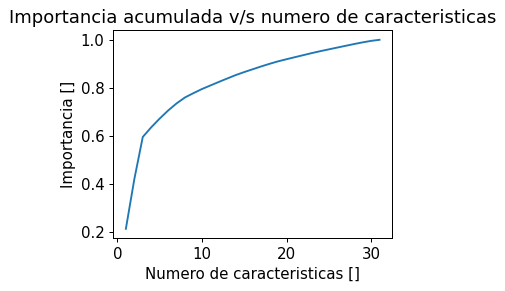

In [ ]:
plt.figure(figsize=(4, 3), dpi=90)
plt.plot(numero_caracteristicas, suma_lista)
plt.xlabel("Numero de caracteristicas []")
plt.ylabel("Importancia []")
plt.title("Importancia acumulada v/s numero de caracteristicas")
plt.show()

In [ ]:
suma_lista = []
numero_caracteristicas = []

suma = 0
for i in range(len(ranking_clases)): #Escogemos el ranking a trabajar
    if suma < 0.6: #Definimos el grado de importancia a acumular
        suma += ranking_clases[i][0]
        print(ranking_clases[i][1])
    if suma >= 0.6:
        print(i)
        break

print(f"Importancia acumulada:{suma}")

Amplitude_r
MedianAbsDev_b
Gskew_b
iqr_r
3
Importancia acumulada:0.635906558483839


In [ ]:
caracteristicas_irrelevantes = []
for x in range(112-i): #112 caracteristicas en total, el otro minuendo corresponde a las que se quieran eliminar
    caracteristicas_irrelevantes.append(ranking_clases[x+i][1])

In [ ]:
#NOTA: Los resultados que aparecen anteriormente corresponden cuando ya se hizo el feature selection, es por eso que el numero de caractersiticas es de 31 (caso clasificador de clases)

## Matrices de confusion y Metricas

### Clases

In [76]:
#XGBoost
conf_mat_xgb_clases= []
tiempo_xgb_clases =[]
macro_presicion_xgb_clases=[]
macro_recall_xgb_clases=[]
macro_f1_score_xgb_clases=[]

for i in range(5):
    t1=time.time() 

    clf_clases_xgboost= xgboost.XGBClassifier(learning_rate=0.7,max_depth=None, n_estimators=900, objective='multi:softprob',n_jobs=-1)
    clf_clases_xgboost.fit(train_clases.values, np.ravel(label_train_clases.values))

    t2=time.time()

    CM_normalizada = confusion_matrix(label_test_clases.values, clf_clases_xgboost.predict(test_clases.values),normalize='true')
    CM_normal = confusion_matrix(label_test_clases.values, clf_clases_xgboost.predict(test_clases.values))
    macro_presicion_xgb_clases.append(metricas(CM_normal)[0])
    macro_recall_xgb_clases.append(metricas(CM_normal)[1])
    macro_f1_score_xgb_clases.append(metricas(CM_normal)[2])
    tiempo_xgb_clases.append(t2-t1)
    conf_mat_xgb_clases.append(CM_normalizada)
    print(f"{i+1}/5")

1/5
2/5
3/5
4/5
5/5


In [77]:
print(f'Macro_Presicion: {round(statistics.mean(macro_presicion_xgb_clases),4)*100} \u00B1 {round(statistics.pstdev(macro_presicion_xgb_clases),4)*100}')
print(f'Macro_Recall: {round(statistics.mean(macro_recall_xgb_clases),4)*100} \u00B1 {round(statistics.pstdev(macro_recall_xgb_clases),4)*100}')
print(f'Macro_F1_Score: {round(statistics.mean(macro_f1_score_xgb_clases),3)*100} \u00B1 {round(statistics.pstdev(macro_f1_score_xgb_clases),3)*100}')
print(f'Tiempo: {round(statistics.mean(tiempo_xgb_clases),2)} \u00B1 {round(statistics.pstdev(tiempo_xgb_clases),2)} [s]')

Macro_Presicion: 94.37 ± 0.0
Macro_Recall: 94.47 ± 0.0
Macro_F1_Score: 94.39999999999999 ± 0.0
Tiempo: 23.46 ± 0.15 [s]


In [78]:
#BRF
conf_mat_BRF_clases= []
tiempo_BRF_clases =[]
macro_presicion_BRF_clases=[]
macro_recall_BRF_clases=[]
macro_f1_score_BRF_clases=[]

for i in range(5):
    t1=time.time() 
    clf_clases_brf= BalancedRandomForestClassifier(n_estimators=700,
                                criterion="gini",
                                max_features="sqrt",
                                sampling_strategy="all",
                                max_depth=None,
                                n_jobs=-1)
                                
    clf_clases_brf.fit(train_clases.values, np.ravel(label_train_clases.values))
    t2=time.time()
    CM_normalizada = confusion_matrix(label_test_clases.values, clf_clases_brf.predict(test_clases.values),normalize='true')
    CM_normal = confusion_matrix(label_test_clases.values, clf_clases_brf.predict(test_clases.values))

    macro_presicion_BRF_clases.append(metricas(CM_normal)[0])
    macro_recall_BRF_clases.append(metricas(CM_normal)[1])
    macro_f1_score_BRF_clases.append(metricas(CM_normal)[2])
    tiempo_BRF_clases.append(t2-t1)
    conf_mat_BRF_clases.append(CM_normalizada)
    print(f"{i+1}/5")

1/5
2/5
3/5
4/5
5/5


In [79]:
print(f'Macro_Presicion: {round(statistics.mean(macro_presicion_BRF_clases),4)*100} \u00B1 {round(statistics.pstdev(macro_presicion_BRF_clases),4)*100}')
print(f'Macro_Recall: {round(statistics.mean(macro_recall_BRF_clases),4)*100} \u00B1 {round(statistics.pstdev(macro_recall_BRF_clases),4)*100}')
print(f'Macro_F1_Score: {round(statistics.mean(macro_f1_score_BRF_clases),3)*100} \u00B1 {round(statistics.pstdev(macro_f1_score_BRF_clases),3)*100}')
print(f'Tiempo: {round(statistics.mean(tiempo_BRF_clases),2)} \u00B1 {round(statistics.pstdev(tiempo_BRF_clases),2)} [s]')

Macro_Presicion: 89.83 ± 0.11
Macro_Recall: 93.02 ± 0.05
Macro_F1_Score: 91.3 ± 0.1
Tiempo: 3.18 ± 0.09 [s]


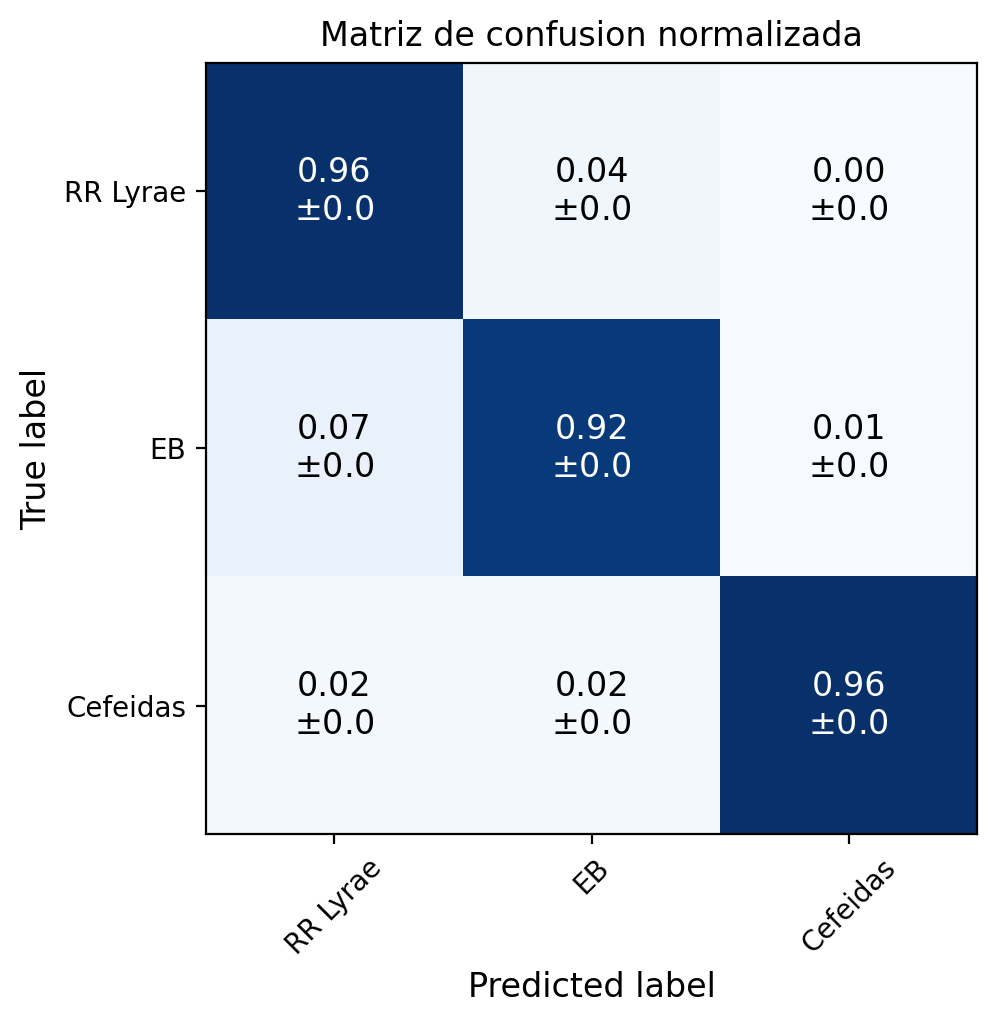

In [81]:
#Matriz de Confusion XGBoost
plt.figure(figsize=(5,5), dpi=200)
plt.title("Matriz de confusion normalizada")
plot_confusion_matrix_2(matrices(conf_mat_xgb_clases)[0], matrices(conf_mat_xgb_clases)[1], classes=target_names_clases)

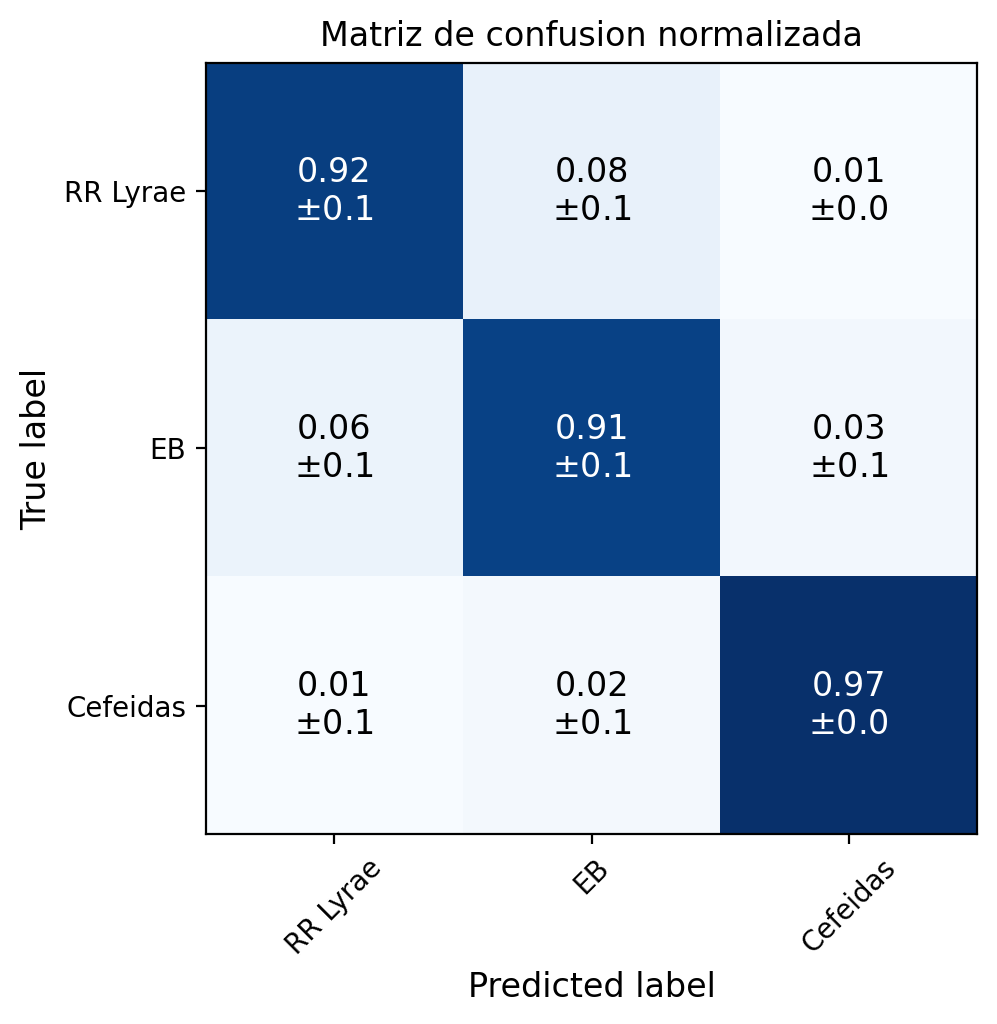

In [82]:
#Matriz de Confusion BRF
plt.figure(figsize=(5,5), dpi=200)
plt.title("Matriz de confusion normalizada")
plot_confusion_matrix_2(matrices(conf_mat_BRF_clases)[0], matrices(conf_mat_BRF_clases)[1], classes=target_names_clases)

### RRL

In [83]:
#BRF
conf_mat_BRF_rrl= []
tiempo_BRF_rrl =[]
macro_presicion_BRF_rrl=[]
macro_recall_BRF_rrl=[]
macro_f1_score_BRF_rrl=[]

for i in range(5):
    t1=time.time() 
    clf_BRF_RRL = BalancedRandomForestClassifier(n_estimators=700,
                                criterion="gini",
                                max_features="sqrt",
                                sampling_strategy="all",
                                max_depth=None,
                                n_jobs=-1)

    clf_BRF_RRL.fit(train_RRL.values, np.ravel(label_train_RRL.values))

    t2=time.time()
    CM_normalizada = confusion_matrix(label_test_RRL.values, clf_BRF_RRL.predict(test_RRL.values),normalize='true')
    CM_normal = confusion_matrix(label_test_RRL.values, clf_BRF_RRL.predict(test_RRL.values))

    macro_presicion_BRF_rrl.append(metricas(CM_normal)[0])
    macro_recall_BRF_rrl.append(metricas(CM_normal)[1])
    macro_f1_score_BRF_rrl.append(metricas(CM_normal)[2])
    tiempo_BRF_rrl.append(t2-t1)
    conf_mat_BRF_rrl.append(CM_normalizada)
    print(f"{i+1}/5")

1/5
2/5
3/5
4/5
5/5


In [84]:
print(f'Macro_Presicion: {round(statistics.mean(macro_presicion_BRF_rrl),4)*100} \u00B1 {round(statistics.pstdev(macro_presicion_BRF_rrl),4)*100}')
print(f'Macro_Recall: {round(statistics.mean(macro_recall_BRF_rrl),4)*100} \u00B1 {round(statistics.pstdev(macro_recall_BRF_rrl),4)*100}')
print(f'Macro_F1_Score: {round(statistics.mean(macro_f1_score_BRF_rrl),3)*100} \u00B1 {round(statistics.pstdev(macro_f1_score_BRF_rrl),3)*100}')
print(f'Tiempo: {round(statistics.mean(tiempo_BRF_rrl),2)} \u00B1 {round(statistics.pstdev(tiempo_BRF_rrl),2)} [s]')

Macro_Presicion: 44.6 ± 0.31
Macro_Recall: 60.160000000000004 ± 0.5700000000000001
Macro_F1_Score: 44.3 ± 0.3
Tiempo: 2.22 ± 0.1 [s]


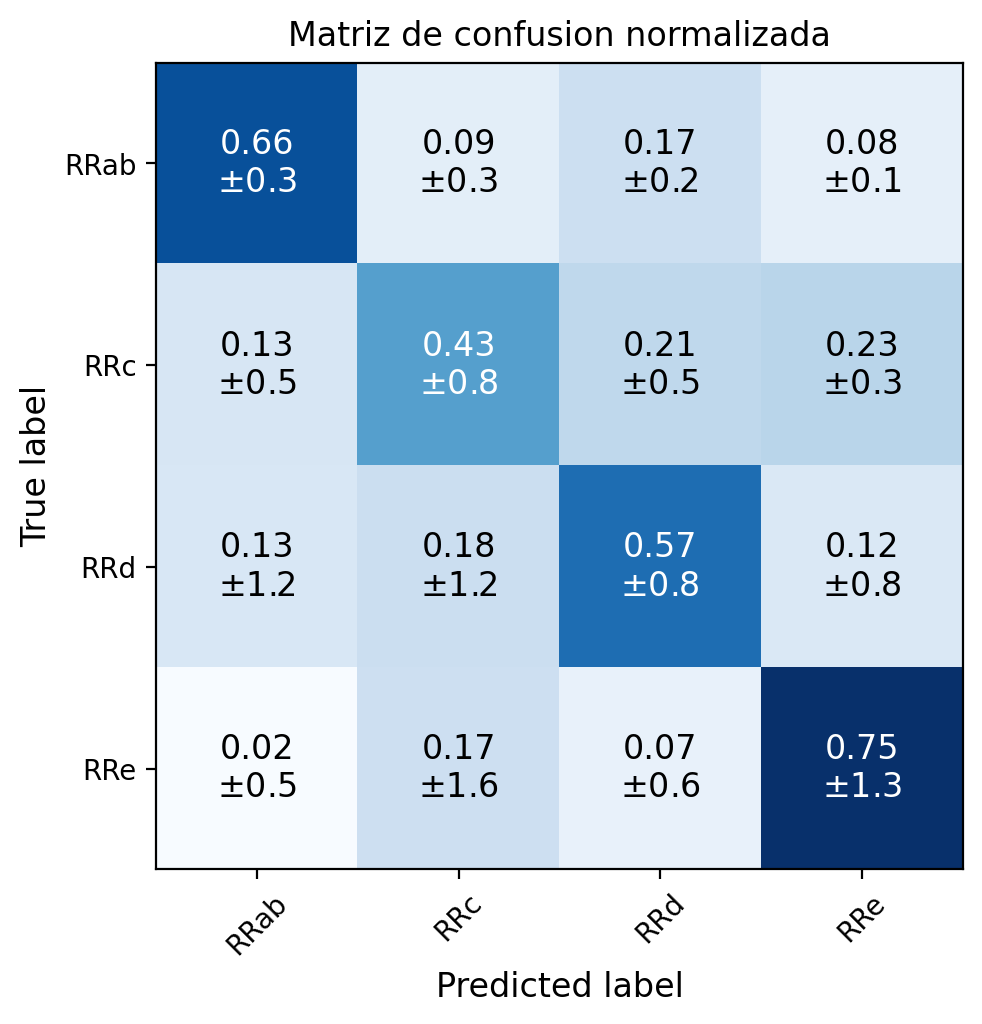

In [85]:
plt.figure(figsize=(5,5), dpi=200)
plt.title("Matriz de confusion normalizada")
plot_confusion_matrix_2(matrices(conf_mat_BRF_rrl)[0], matrices(conf_mat_BRF_rrl)[1], classes=target_names_RRL)

### EB

In [86]:
#BRF
conf_mat_BRF_eb= []
tiempo_BRF_eb =[]
macro_presicion_BRF_eb=[]
macro_recall_BRF_eb=[]
macro_f1_score_BRF_eb=[]

for i in range(5):
    t1=time.time() 
    clf_BRF_EB = BalancedRandomForestClassifier(n_estimators=600,
                                criterion="gini",
                                max_features="sqrt",
                                sampling_strategy="all",
                                max_depth=None,
                                n_jobs=-1)

    clf_BRF_EB.fit(train_EB.values, np.ravel(label_train_EB.values))

    t2=time.time()
    CM_normalizada = confusion_matrix(label_test_EB.values, clf_BRF_EB.predict(test_EB.values),normalize='true')
    CM_normal = confusion_matrix(label_test_EB.values, clf_BRF_EB.predict(test_EB.values))

    macro_presicion_BRF_eb.append(metricas(CM_normal)[0])
    macro_recall_BRF_eb.append(metricas(CM_normal)[1])
    macro_f1_score_BRF_eb.append(metricas(CM_normal)[2])
    tiempo_BRF_eb.append(t2-t1)
    conf_mat_BRF_eb.append(CM_normalizada)
    print(f"{i+1}/5")

1/5
2/5
3/5
4/5
5/5


In [87]:
print(f'Macro_Presicion: {round(statistics.mean(macro_presicion_BRF_eb),4)*100} \u00B1 {round(statistics.pstdev(macro_presicion_BRF_eb),4)*100}')
print(f'Macro_Recall: {round(statistics.mean(macro_recall_BRF_eb),4)*100} \u00B1 {round(statistics.pstdev(macro_recall_BRF_eb),4)*100}')
print(f'Macro_F1_Score: {round(statistics.mean(macro_f1_score_BRF_eb),3)*100} \u00B1 {round(statistics.pstdev(macro_f1_score_BRF_eb),3)*100}')
print(f'Tiempo: {round(statistics.mean(tiempo_BRF_eb),2)} \u00B1 {round(statistics.pstdev(tiempo_BRF_eb),2)} [s]')

Macro_Presicion: 45.51 ± 1.28
Macro_Recall: 53.769999999999996 ± 3.52
Macro_F1_Score: 44.7 ± 1.7999999999999998
Tiempo: 0.94 ± 0.03 [s]


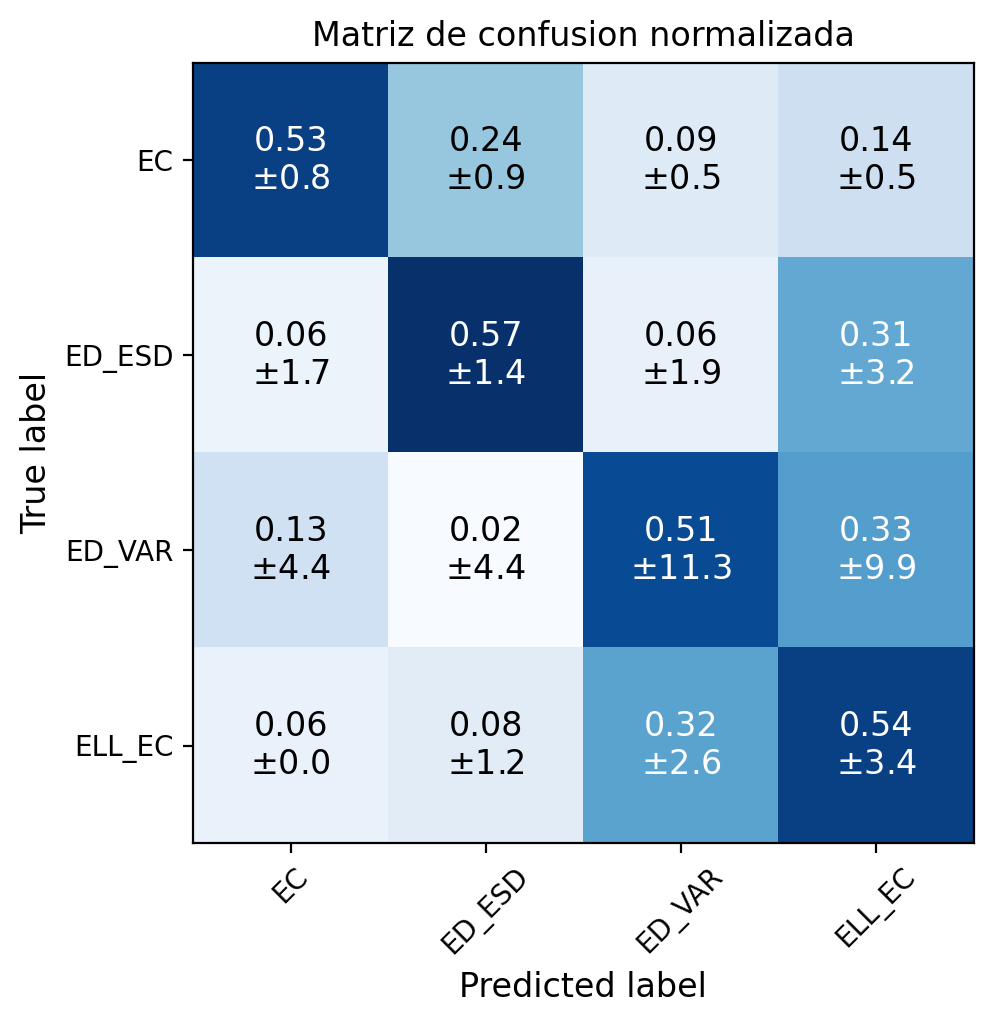

In [89]:
plt.figure(figsize=(5,5), dpi=200)
plt.title("Matriz de confusion normalizada")
plot_confusion_matrix_2(matrices(conf_mat_BRF_eb)[0], matrices(conf_mat_BRF_eb)[1], classes=target_names_EB)

### Cefeidas

In [103]:
#BRF
conf_mat_BRF_cef= []
tiempo_BRF_cef =[]
macro_presicion_BRF_cef=[]
macro_recall_BRF_cef=[]
macro_f1_score_BRF_cef=[]

for i in range(5):
    t1=time.time() 
    clf_BRF_CEF = BalancedRandomForestClassifier(n_estimators=800,
                                criterion="gini",
                                max_features="sqrt",
                                sampling_strategy="all",
                                max_depth=None,
                                n_jobs=-1)

    clf_BRF_CEF.fit(train_CEF.values, np.ravel(label_train_CEF.values))

    t2=time.time()
    CM_normalizada = confusion_matrix(label_test_CEF.values, clf_BRF_CEF.predict(test_CEF.values),normalize='true')
    CM_normal = confusion_matrix(label_test_CEF.values, clf_BRF_CEF.predict(test_CEF.values))

    macro_presicion_BRF_cef.append(metricas(CM_normal)[0])
    macro_recall_BRF_cef.append(metricas(CM_normal)[1])
    macro_f1_score_BRF_cef.append(metricas(CM_normal)[2])
    tiempo_BRF_cef.append(t2-t1)
    conf_mat_BRF_cef.append(CM_normalizada)
    print(f"{i+1}/5")

1/5
2/5
3/5
4/5
5/5


In [104]:
print(f'Macro_Presicion: {round(statistics.mean(macro_presicion_BRF_cef),4)*100} \u00B1 {round(statistics.pstdev(macro_presicion_BRF_cef),4)*100}')
print(f'Macro_Recall: {round(statistics.mean(macro_recall_BRF_cef),4)*100} \u00B1 {round(statistics.pstdev(macro_recall_BRF_cef),4)*100}')
print(f'Macro_F1_Score: {round(statistics.mean(macro_f1_score_BRF_cef),3)*100} \u00B1 {round(statistics.pstdev(macro_f1_score_BRF_cef),3)*100}')
print(f'Tiempo: {round(statistics.mean(tiempo_BRF_cef),2)} \u00B1 {round(statistics.pstdev(tiempo_BRF_cef),2)} [s]')

Macro_Presicion: 69.43 ± 0.26
Macro_Recall: 83.74000000000001 ± 0.49
Macro_F1_Score: 71.7 ± 0.3
Tiempo: 1.31 ± 0.01 [s]


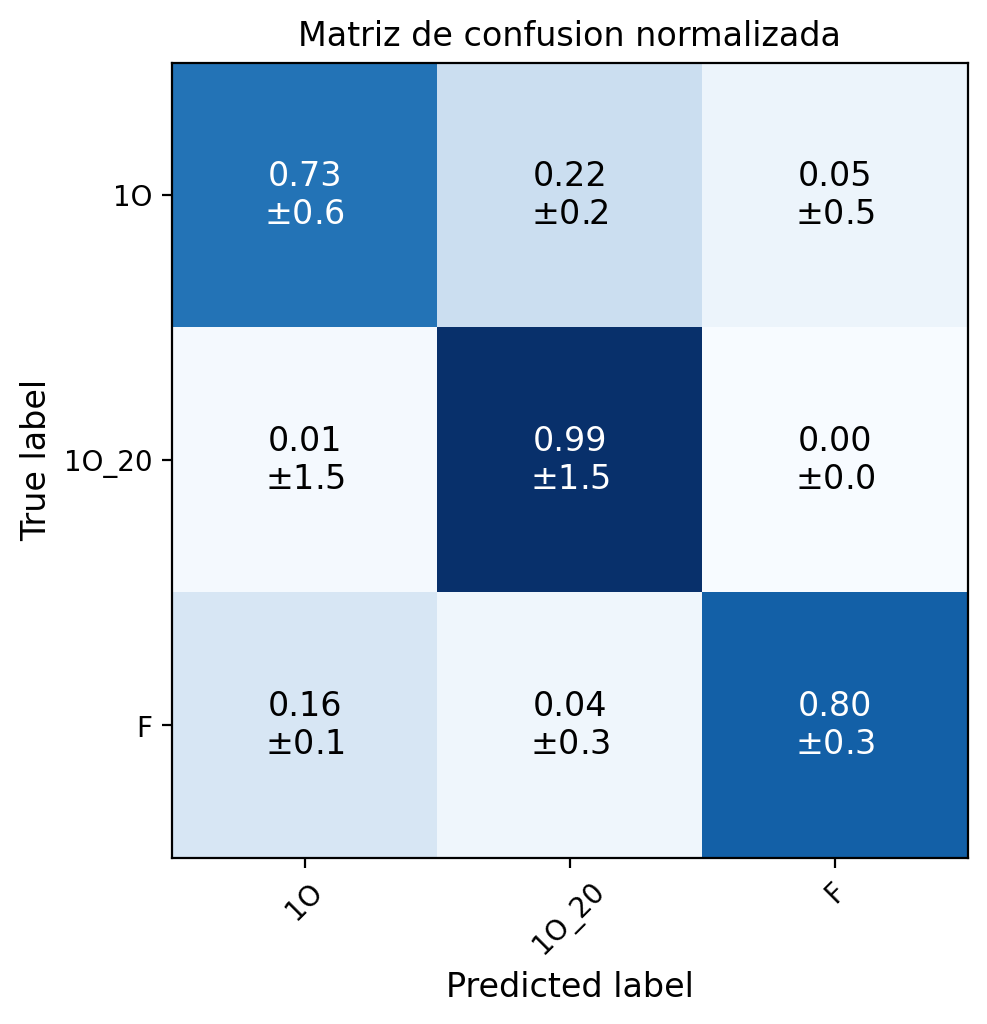

In [93]:
plt.figure(figsize=(5,5), dpi=200)
plt.title("Matriz de confusion normalizada")
plot_confusion_matrix_2(matrices(conf_mat_BRF_cef)[0], matrices(conf_mat_BRF_cef)[1], classes=target_names_CEF)

### Final

In [49]:
conf_mat_final= []
tiempo_final =[]
macro_presicion_final=[]
macro_recall_final=[]
macro_f1_score_final=[]

for i in range(5):
    t1=time.time() 

    ################ ENTRENAMIENTO ################
    clf_clases= xgboost.XGBClassifier(learning_rate=0.7,max_depth=None, n_estimators=900, objective='multi:softprob',n_jobs=-1)
    clf_clases.fit(train_clases.values, np.ravel(label_train_clases.values))


    clf_BRF_RRL = BalancedRandomForestClassifier(n_estimators=700,
                                criterion="gini",
                                max_features="sqrt",
                                sampling_strategy="all",
                                max_depth=None,
                                n_jobs=-1)

    clf_BRF_RRL.fit(train_RRL.values, np.ravel(label_train_RRL.values))


    clf_BRF_EB = BalancedRandomForestClassifier(n_estimators=600,
                                criterion="gini",
                                max_features="sqrt",
                                sampling_strategy="all",
                                max_depth=None,
                                n_jobs=-1)

    clf_BRF_EB.fit(train_EB.values, np.ravel(label_train_EB.values))


    clf_BRF_CEF = BalancedRandomForestClassifier(n_estimators=800,
                                criterion="gini",
                                max_features="sqrt",
                                sampling_strategy="all",
                                max_depth=None,
                                n_jobs=-1)

    clf_BRF_CEF.fit(train_CEF.values, np.ravel(label_train_CEF.values))

    ################ ENTRENAMIENTO ################

    t2=time.time()
    
    ################ PREDICCIONES FINALES ################
    predicciones = []
    clase_predicha = clf_clases.predict(test_subclases_final.values)
    for m in range(len(clase_predicha)):

        if clase_predicha[m]==0:
            subclase_predicha = clf_BRF_RRL.predict(test_todos_RRL.values[m].reshape(1, -1))
            predicciones.append(subclase_predicha[0])

        elif clase_predicha[m] ==1:
            subclase_predicha = clf_BRF_EB.predict(test_todos_EB.values[m].reshape(1, -1))
            predicciones.append(subclase_predicha[0]+4)

        else:
            if clase_predicha[m] == 2:
                subclase_predicha = clf_BRF_CEF.predict(test_todos_CEF.values[m].reshape(1, -1))
                predicciones.append(subclase_predicha[0]+11)
    ################ PREDICCIONES FINALES ################

    CM_normalizada = confusion_matrix(label_test_subclases.values, predicciones,normalize='true')
    CM_normal = confusion_matrix(label_test_subclases.values, predicciones)

    macro_presicion_final.append(metricas(CM_normal)[0])
    macro_recall_final.append(metricas(CM_normal)[1])
    macro_f1_score_final.append(metricas(CM_normal)[2])
    tiempo_final.append(t2-t1)
    conf_mat_final.append(CM_normalizada)
    print(f"{i+1}/5")

1/5
2/5
3/5
4/5
5/5


In [50]:
print(f'Macro_Presicion: {round(statistics.mean(macro_presicion_final),4)*100} \u00B1 {round(statistics.pstdev(macro_presicion_final),4)*100}')
print(f'Macro_Recall: {round(statistics.mean(macro_recall_final),4)*100} \u00B1 {round(statistics.pstdev(macro_recall_final),4)*100}')
print(f'Macro_F1_Score: {round(statistics.mean(macro_f1_score_final),3)*100} \u00B1 {round(statistics.pstdev(macro_f1_score_final),3)*100}')
print(f'Tiempo: {round(statistics.mean(tiempo_final),2)} \u00B1 {round(statistics.pstdev(tiempo_final),2)} [s]')

Macro_Presicion: 46.489999999999995 ± 0.13999999999999999
Macro_Recall: 61.839999999999996 ± 0.3
Macro_F1_Score: 47.699999999999996 ± 0.2
Tiempo: 27.52 ± 0.39 [s]


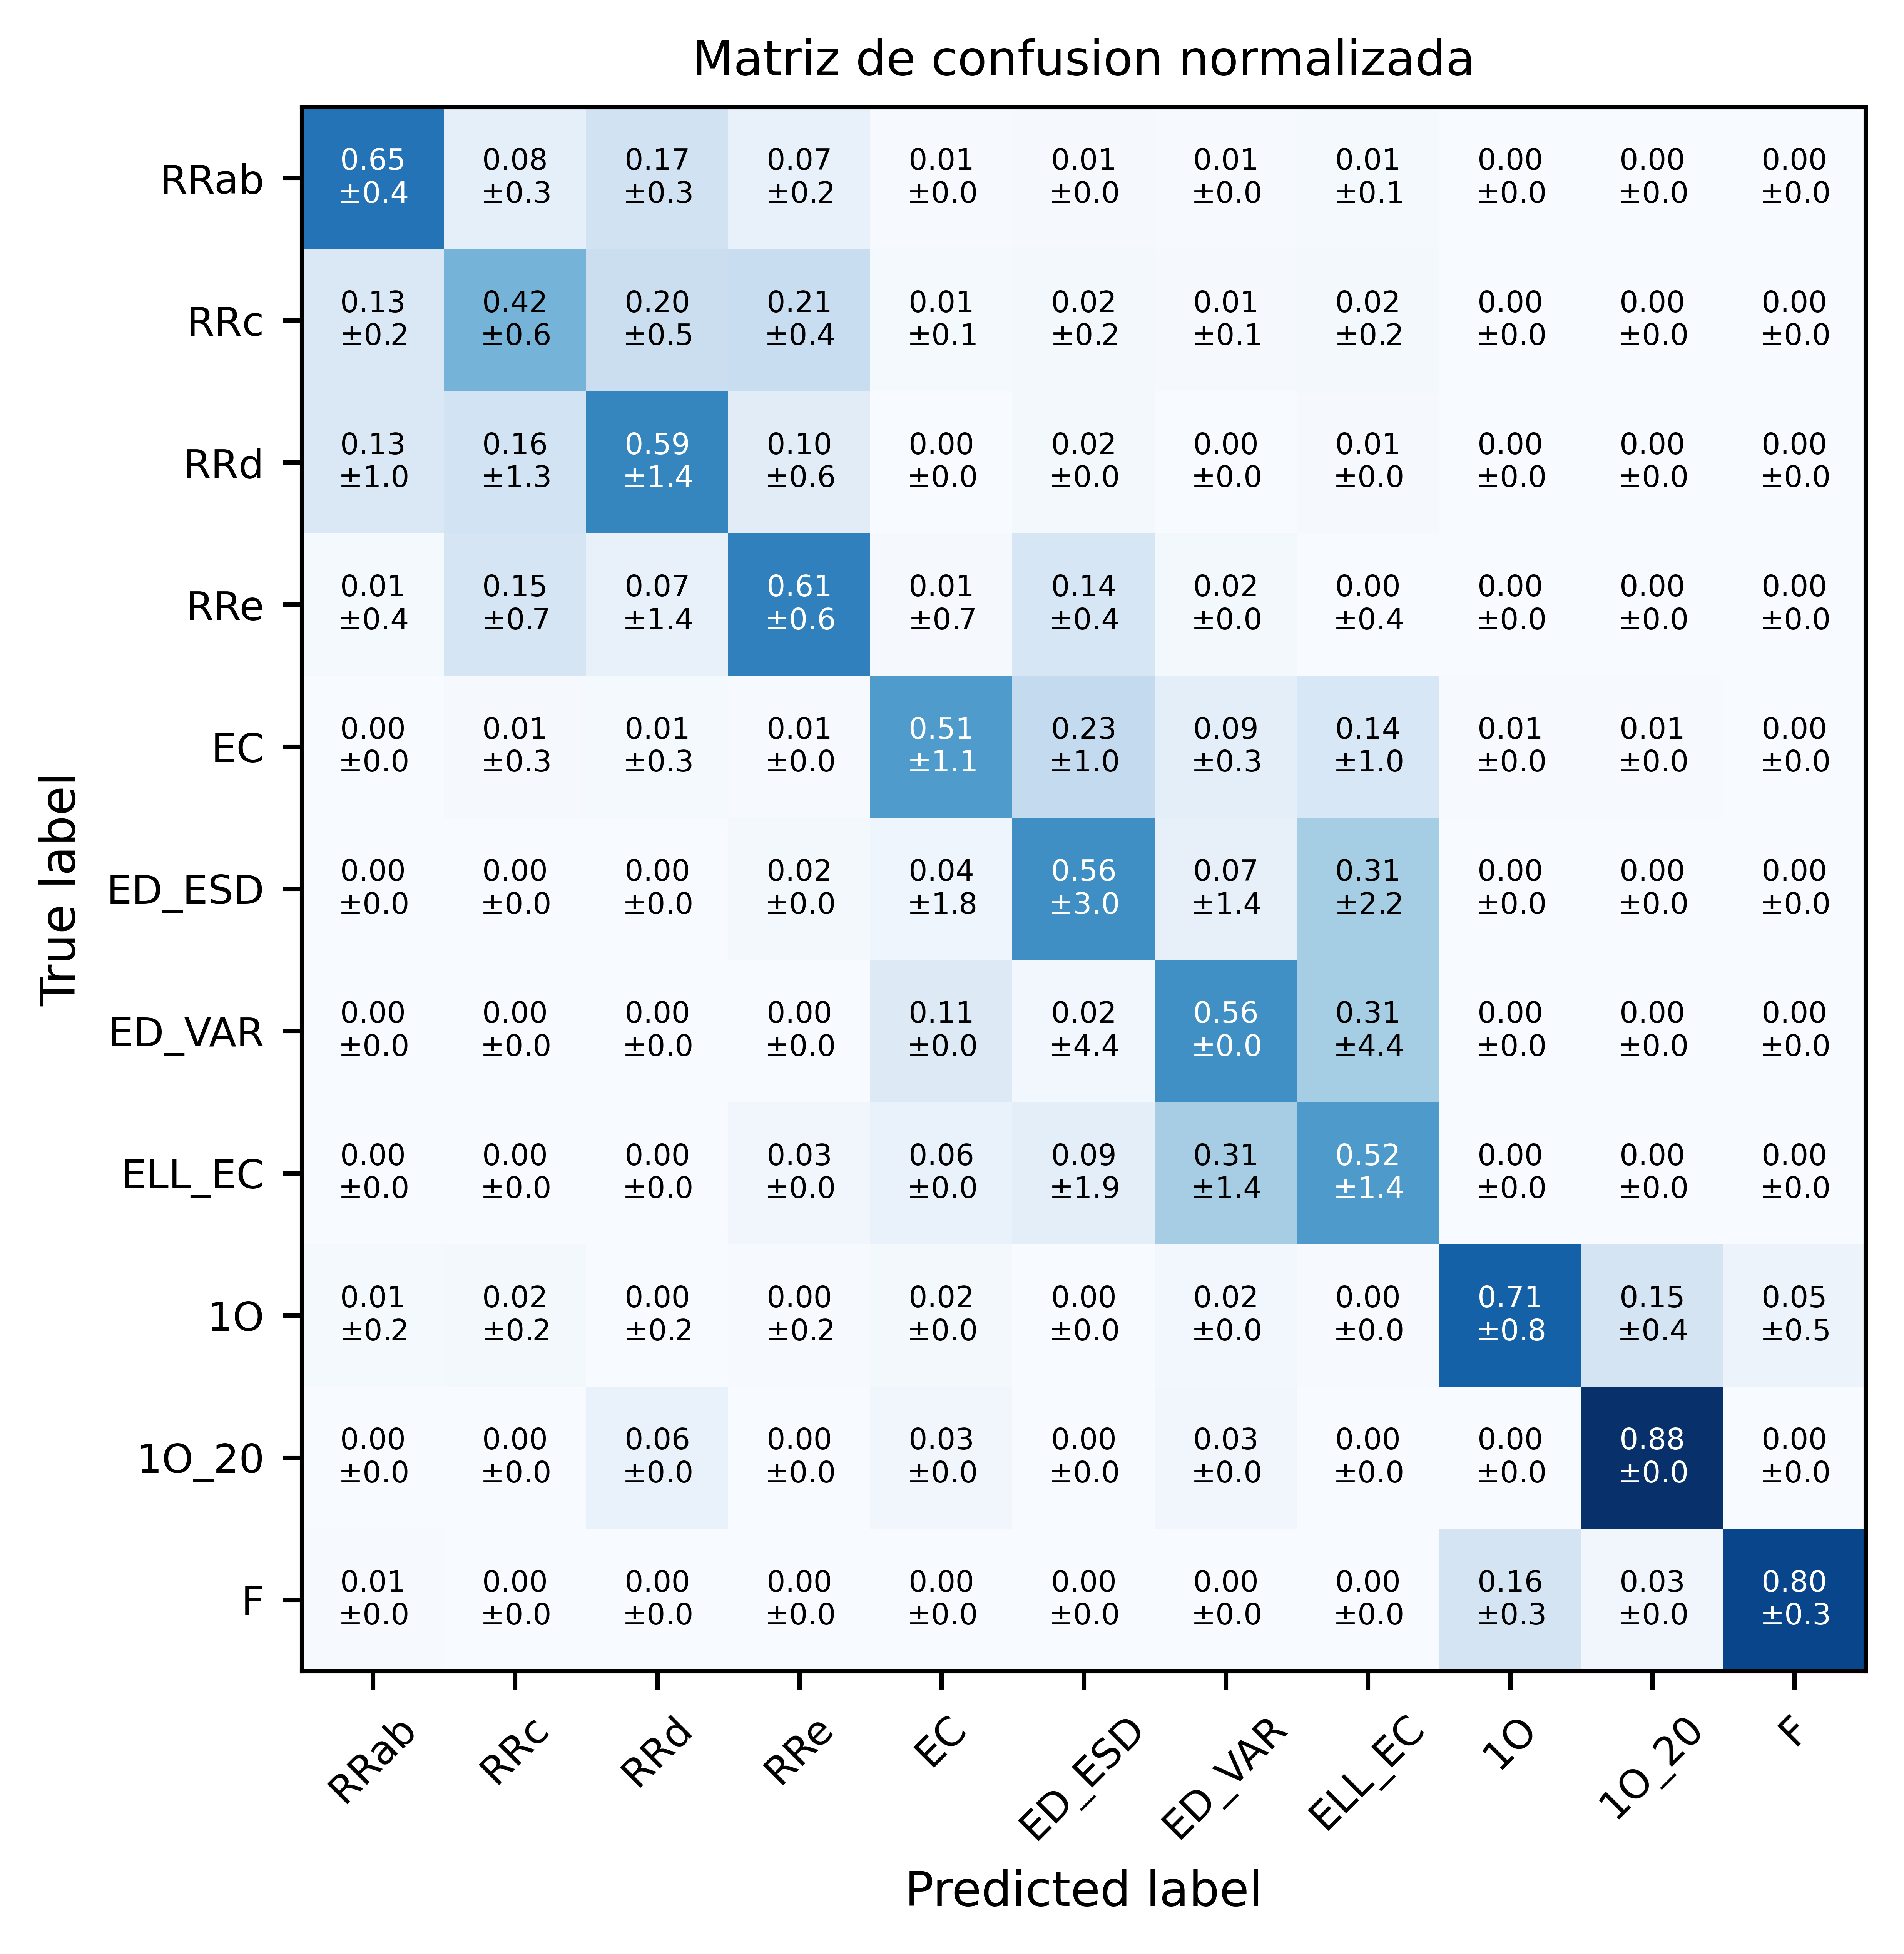

In [99]:
plt.figure(figsize=(5,5), dpi=1000)
plt.title("Matriz de confusion normalizada", fontsize= 9)
plot_confusion_matrix_2(matrices(conf_mat_final)[0], matrices(conf_mat_final)[1], classes=target_final, fontsize_valores=5.5, fontsize_label=7.5, fontsize_eje=9)